In [236]:
#Required Imports
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import matplotlib
import hvplot.pandas

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, make_scorer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import shap

In [169]:
pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [7]:
data = pd.read_csv("data/processed/all_data_cleaned_grouped.csv")

# Drop missing values

In [8]:
for col in data.columns:
    missing = data[col].isna().sum()
    if missing > 0:
        print(f"{col}: { missing * 100/ data.shape[0]}%")

dti: 0.07577908293579948%
revol_util: 0.07803783993739256%
mort_acc: 2.0940448978886823%
pub_rec_bankruptcies: 0.030869679021772203%


In [9]:
print(f"Before drop: {data.shape}")
data.dropna(axis = 0, inplace = True)
print(f"After drop: {data.shape}")


Before drop: (2257879, 26)
After drop: (2207191, 26)


In [10]:
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove("loan_status")
categorical_cols = data.select_dtypes(exclude=['number']).columns.tolist()

# Train-test split

In [11]:
X = data.drop(columns = ["loan_status"])
y = data["loan_status"]

X_cols = X.columns
y_col = ["loan_status"]

In [12]:
#Splitting dataset into train and test sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
X_train.head()

,loan_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,term_months,earliest_cr_line_year,earliest_cr_line_month
1196574,6500.0,10.99,212.78,B,3,4.0,MORTGAGE,55500.0,Not Verified,credit_card,...,15887.0,58.0,45.0,w,Individual,2.0,0.0,36,1985,9
322550,11175.0,25.57,447.70,F,5,4.0,RENT,45000.0,Source Verified,car,...,2029.0,88.2,13.0,f,Individual,0.0,0.0,36,2012,1
912078,15250.0,26.30,459.31,E,5,0.0,MORTGAGE,50000.0,Not Verified,debt_consolidation,...,10008.0,37.9,25.0,w,Individual,0.0,0.0,60,1983,6
1937685,10000.0,8.99,207.54,B,1,5.0,RENT,95000.0,Not Verified,credit_card,...,12733.0,32.2,20.0,f,Individual,0.0,0.0,60,2002,9
755565,16000.0,10.08,516.88,B,1,10.0,MORTGAGE,120000.0,Not Verified,debt_consolidation,...,45330.0,68.0,50.0,w,Individual,4.0,0.0,36,1992,8


In [14]:
X_train.shape

(1765752, 25)

# Oversampling

In [15]:
train_df = pd.concat([X_train, y_train], axis = 1)
train_df.shape

(1765752, 26)

In [16]:
from sklearn.utils import resample
#Upsample the minority class (Random Oversampling)

#Separate majority and minority classes
majority_class = train_df[train_df['loan_status'] == 1]  # Fully Paid (1)
minority_class = train_df[train_df['loan_status'] == 0]  # Charged Off (0)

#Upsample minority class
minority_class_upsampled = resample(
    minority_class, 
    replace=True,     
    n_samples=int(len(majority_class)/2), 
    random_state=42
)

train_df_balanced = pd.concat([majority_class, minority_class_upsampled])
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_balanced = train_df_balanced.drop(columns=['loan_status'])
y_train_balanced = train_df_balanced['loan_status']

In [17]:
#Verification Point - We have converted it to 2:1 ratio
y_train_balanced.value_counts()

loan_status
1    1535993
0     767996
Name: count, dtype: int64

# Pipeline

In [18]:
def create_pipeline(numerical_cols, categorical_cols, classifier = None, gridcv = None):
    # Define preprocessing steps
    numerical_transformer = Pipeline(steps=[
        # ('imputer', SimpleImputer(strategy='median')),  #Impute missing values with median (Right Skewed numerical features)
        ('scaler', MinMaxScaler())  # Standard Scaling
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  #Fill missing categorical values with "missing"
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  #OneHotEncoding
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    # Define the pipeline with preprocessing + model/grid
    if classifier:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', classifier)
        ])
    elif gridcv:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('grid_search', gridcv)
        ])
    else:
        return "Error. Provide a classifier or grid serach instance"

    return pipeline

In [63]:
#Model Evaluation
def evaluate_model(model, model_name, train_combined, y_train, test_combined, y_test, threshold = 0.5):
    def calculate_metrics(predictions, probabilities, y_true):
        accuracy = accuracy_score(y_true, predictions)
        precision = precision_score(y_true, predictions)
        recall = recall_score(y_true, predictions)
        f1 = f1_score(y_true, predictions)
        roc_auc = roc_auc_score(y_true, probabilities)
        return accuracy, precision, recall, f1, roc_auc

    def print_metrics(accuracy, precision, recall, f1, roc_auc, dataset_name):
        print(f"\n{dataset_name} Set Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")

    def plot_confusion_matrix(y_true, predictions, dataset_name):
        conf_matrix = confusion_matrix(y_true, predictions)
        plt.figure(figsize=(7, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
                    xticklabels=['Class 0', 'Class 1'],
                    yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix ({dataset_name} Set')
        plt.show()

    def plot_roc_curve(y_true, probabilities, dataset_name):
        fpr, tpr, _ = roc_curve(y_true, probabilities)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal reference line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve ({dataset_name} Set')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def print_classification_report(y_true, predictions, dataset_name):
        report = classification_report(y_true, predictions, target_names=['Class 0', 'Class 1'])
        print(f"Classification Report ({dataset_name} Set:\n", report)

    # Print the model name for reference
    print(f"\n=== Evaluation Results for {model_name}===")

    # Test set evaluation
    test_probabilities = model.predict_proba(test_combined)[:, 1]
    test_predictions = (test_probabilities >= threshold).astype(int)
    test_metrics = calculate_metrics(test_predictions, test_probabilities, y_test)
    print_metrics(*test_metrics, "Test")
    plot_confusion_matrix(y_test, test_predictions, "Test")
    plot_roc_curve(y_test, test_probabilities, "Test")
    print_classification_report(y_test, test_predictions, "Test")
    return test_probabilities

## LGBM default

In [41]:
classifier = LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
# classifier.fit(X_train_balanced, y_train_balanced)
pipeline = create_pipeline(numerical_cols, categorical_cols, classifier = classifier)
pipeline.fit(X_train_balanced, y_train_balanced)
pipeline

[LightGBM] [Info] Number of positive: 1535993, number of negative: 767996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 2303989, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.666667 -> initscore=0.693148
[LightGBM] [Info] Start training from score 0.693148


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'sub_grade',
                                                   'emp_length', 'annual_inc',
                                                   'dti', 'open_acc', 'pub_rec',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc', 'mort_acc',
                                                   'pub_rec_bankruptcies',
                                                   'term_months',
                                                   'earliest_cr_line_year',
                                                   'earliest_cr_line_month']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grade', 'home_ownership',
                                                   'verification_status',
                                                   'purpose', 'title',
                                                   'addr_state',
                                                   'initial_list_status',
                                                   'application_type'])])),
                ('model',
                 LGBMClassifier(max_depth=6, n_estimators=200,
                                random_state=42))])


=== Evaluation Results for LGBM Model===

Test Set Metrics:
Accuracy: 0.8183
Precision: 0.9019
Recall: 0.8877
F1 Score: 0.8947
ROC AUC: 0.7419


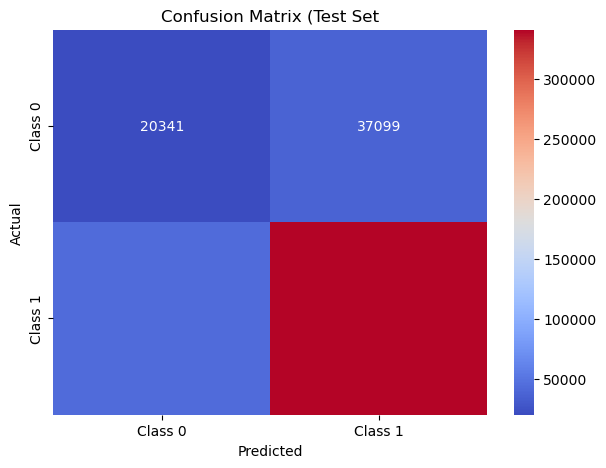

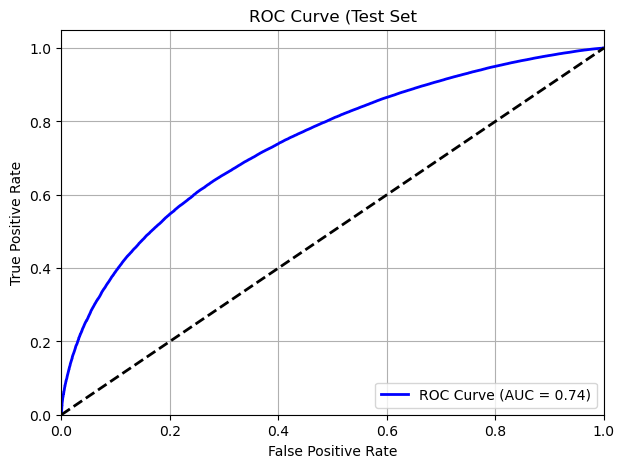

Classification Report (Test Set:
               precision    recall  f1-score   support

     Class 0       0.32      0.35      0.34     57440
     Class 1       0.90      0.89      0.89    383999

    accuracy                           0.82    441439
   macro avg       0.61      0.62      0.62    441439
weighted avg       0.83      0.82      0.82    441439



In [42]:
#Model Evaluation
evaluate_model(
    model=pipeline,
    model_name="LGBM Model",
    train_combined=X_train_balanced,
    y_train=y_train_balanced,
    test_combined=X_test,
    y_test=y_test
)

## XGBoost

In [64]:
# classifier = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
pipeline = create_pipeline(numerical_cols, categorical_cols, classifier = XGBClassifier(random_state=100))
pipeline.fit(X_train_balanced, y_train_balanced)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'sub_grade',
                                                   'emp_length', 'annual_inc',
                                                   'dti', 'open_acc', 'pub_rec',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc', 'mort_acc',
                                                   'pub_rec_bankruptcies',
                                                   'term_months',
                                                   'earliest_cr_line_year',
                                                   'earliest_cr_line_month...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=100, ...))])


=== Evaluation Results for XGBoost Model===

Test Set Metrics:
Accuracy: 0.7133
Precision: 0.9267
Recall: 0.7280
F1 Score: 0.8154
ROC AUC: 0.7433


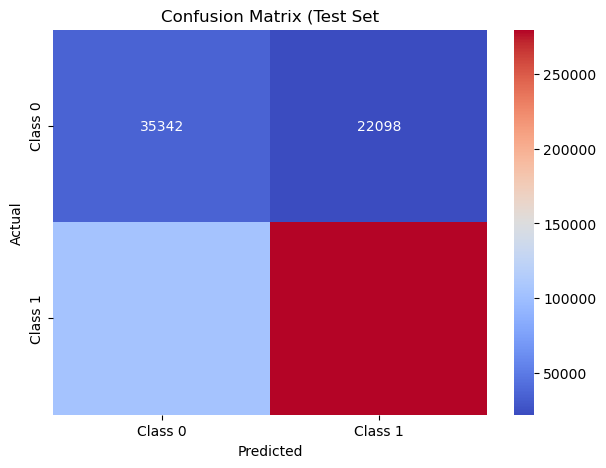

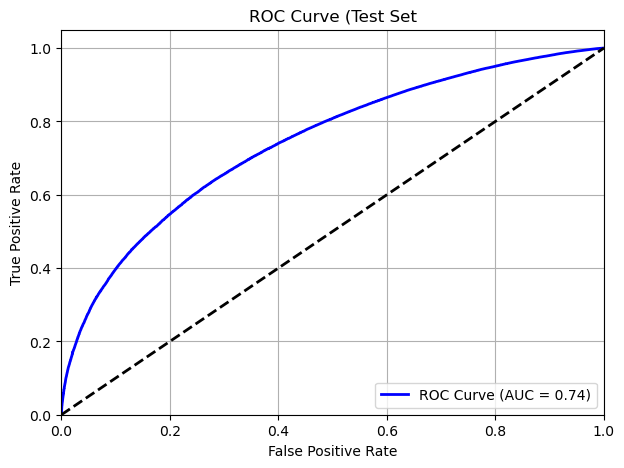

Classification Report (Test Set:
               precision    recall  f1-score   support

     Class 0       0.25      0.62      0.36     57440
     Class 1       0.93      0.73      0.82    383999

    accuracy                           0.71    441439
   macro avg       0.59      0.67      0.59    441439
weighted avg       0.84      0.71      0.76    441439



In [76]:
#Model Evaluation
predictions_proba = evaluate_model(
                    model=pipeline,
                    model_name="XGBoost Model",
                    train_combined=X_train_balanced,
                    y_train=y_train_balanced,
                    test_combined=X_test,
                    y_test=y_test,
                    threshold = 0.62
                )

## XGBoost hyperparameter tuning

In [26]:
# parameter_grid = {
#                   "eta": [0.3, 0.1, 0.05],
#                   "booster": ["gbtree", "dart"],
#                   "lambda": [1, 0.1, 0.05]
#                   }

In [23]:
# def recall_for_class(y_true, y_pred, labels=None, pos_label=1):
#     return recall_score(y_true, y_pred, labels=labels, pos_label=pos_label)

# def create_recall_scorer(pos_label=1):
#   return make_scorer(recall_for_class, pos_label=pos_label)


In [27]:
# grid = GridSearchCV(estimator=XGBClassifier(), param_grid=parameter_grid, scoring=create_recall_scorer(pos_label=0))

In [ ]:
# pipeline = create_pipeline(numerical_cols, categorical_cols, gridcv = grid)
# pipeline.fit(X_train_balanced, y_train_balanced)
# pipeline

In [ ]:
# best_params = pipeline.named_steps["grid_search"].best_params_

# SHAP values
Get dataframe with SHAP values per sample

In [22]:
shap.initjs()

In [128]:
def get_shap(X_test, prediction_proba, y_test, pipeline):
    model = pipeline.named_steps["model"]
    preprocessor = pipeline.named_steps["preprocessor"]

    explainer = shap.TreeExplainer(model)
    X_test_transformed = preprocessor.transform(X_test)
    
    feature_names = pipeline[:-1].get_feature_names_out()
    rename_features = []
    for name in feature_names:
        rename_features.append(name[5:])

    X_test_transformed_df = pd.DataFrame( X_test_transformed.toarray(), columns = rename_features)
    for col in X_test.columns:
        if col in X_test_transformed_df.columns:
            X_test_transformed_df[col] = X_test.reset_index(drop = True)[col]

    shap_vals = explainer.shap_values(X_test_transformed)

    shap_df = pd.DataFrame(columns = rename_features, data = shap_vals)
    shap_df["Prediction Proba"] = prediction_proba
    shap_df["Target"] = y_test.reset_index(drop = True)

    return X_test_transformed_df, shap_df

In [129]:
X_test_transformed, X_test_shap = get_shap(X_test, predictions_proba, y_test, pipeline)

In [130]:
X_test_transformed.head()

,loan_amnt,int_rate,installment,sub_grade,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,...,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App
0,5000.0,13.99,170.87,3,4.0,22680.0,23.61,5.0,0.0,4200.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,4375.0,15.99,153.80,5,0.5,70000.0,18.55,5.0,0.0,2638.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,35000.0,19.99,927.10,1,10.0,141555.0,15.79,9.0,0.0,36900.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,15000.0,18.94,388.62,2,3.0,72000.0,20.13,6.0,1.0,206.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,3025.0,19.42,111.53,3,10.0,64655.0,14.16,10.0,0.0,5913.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [131]:
X_test_shap.head()

,loan_amnt,int_rate,installment,sub_grade,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,...,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,Prediction Proba,Target
0,0.151707,-0.309311,-0.016923,-0.005849,0.010770,-0.147776,-0.085177,0.174910,0.007480,-0.064157,...,-0.003841,-0.001954,-0.001211,-0.000332,0.024905,0.0,-0.012774,0.0,0.531337,1
1,0.162436,-0.276263,0.110912,-0.172780,-0.038879,0.062768,0.008214,0.169840,0.013174,-0.099606,...,0.198400,-0.000101,-0.000867,-0.000537,0.036792,0.0,-0.007685,0.0,0.677305,1
2,-0.088292,-0.874404,-0.051398,0.226191,0.038157,0.163688,0.015543,0.011530,0.015154,0.241538,...,-0.007974,-0.000437,-0.001895,-0.000340,0.018119,0.0,-0.013604,0.0,0.439310,0
3,-0.044761,0.019172,-0.033732,0.417962,-0.008443,0.029195,-0.016255,0.144786,-0.020869,-0.316588,...,-0.006821,0.000080,-0.001032,-0.000106,0.087271,0.0,-0.017433,0.0,0.812301,1
4,0.228717,-0.246398,0.184627,0.015084,0.061386,0.017530,0.051524,0.028956,0.012954,-0.039837,...,-0.005104,-0.001196,-0.001736,-0.000581,0.031900,0.0,-0.007234,0.0,0.814199,1


In [243]:
def get_sample_plot(df, shap_df, idx = None, significance = 0.05):
    try:
        df_row = df.iloc[idx, :].to_frame().T

        shap_row = shap_df.iloc[idx, :].to_frame().T

        proba = shap_row["Prediction Proba"].values[0]

        target = shap_row["Target"].values[0]
        target = ("Loan Rejected" if target == 0 else "Loan Approved")

        top_shap = shap_row.drop(columns = ["Prediction Proba", "Target"]).T
        top_shap.rename(columns = {top_shap.columns[0]: "Value"}, inplace = True)
        top_shap["Effect"] = top_shap["Value"].apply(lambda x: (-1 if x < 0 else 1))
        top_shap["Value"] = top_shap["Value"].abs()
        top_shap = top_shap.sort_values(by = ["Value"], ascending = False).loc[top_shap["Value"] >= significance]

        print(df_row.head())
        print(f"Default Risk Score: {round(1-proba,2)}")
        print(f"Actual Decision: {target}")

        plt.barh(y = top_shap.index, width = top_shap["Value"], color = top_shap["Effect"].apply(lambda x: ("red" if x == -1 else "green")))
        plt.title(f"Features with importance >= {significance} ")
        legend_items = [matplotlib.lines. Line2D([0], [0], marker='o', color='w', label='+ effect', markerfacecolor='g', markersize=10),
                        matplotlib.lines. Line2D([0], [0], marker='o', color='w', label='- effect', markerfacecolor='r', markersize=10)]
        plt.legend(handles = legend_items)
    except Exception as e:
        return e 


       loan_amnt int_rate installment grade sub_grade emp_length  \
809248  15000.00    18.94      388.62     D         2       3.00   

       home_ownership annual_inc verification_status             purpose  \
809248       MORTGAGE   72000.00            Verified  debt_consolidation   

                     title addr_state   dti open_acc pub_rec revol_bal  \
809248  Debt consolidation         OH 20.13     6.00    1.00    206.00   

       revol_util total_acc initial_list_status application_type mort_acc  \
809248       6.20     15.00                   w       Individual     2.00   

       pub_rec_bankruptcies term_months earliest_cr_line_year  \
809248                 1.00          60                  2003   

       earliest_cr_line_month  
809248                      1  
Default Risk Score: 0.19
Actual Decision: Loan Approved


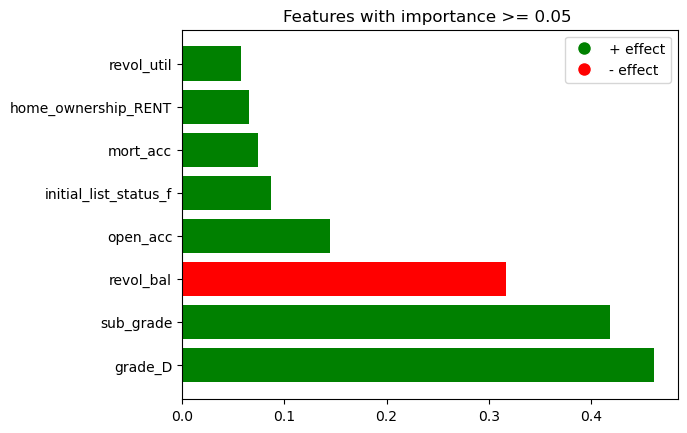

In [247]:
get_sample_plot(X_test, X_test_shap, idx = 3)